# WholeSlideImageSampler demo

This respository aims to develop a tool for sampling from Whole-Slide-Images (WSIs) in an efficient manner. By sampling we mean producing batches of patches which can then be fed to e.g. machine learning algorithms. This should ideally be achieved without storing all the patches on disk (waste of storage). It aims to work with all WSIs that can be read by [openslide](https://github.com/openslide/openslide-python). We also have an implementation of JP2Plus, that would allow to use all the same functionality with jp2 image format. However, user must have matlab engine installed. Sample data is available [here](https://www.dropbox.com/sh/hk676r960zxbqcb/AADrnhTuKRH296GTFwdqWKxca?dl=0).

## Assumptions

- You have WSIs in a format readable by openslide.
- Or you have matlab engine installed
- You may also have multi-resolution-image annotation files, such as those exportable by the slide annotation tool [ASAP](https://github.com/computationalpathologygroup/ASAP) (which supports all openslide readable images). For example, see the folder 'annotation' in the sample data. The annotations can be multi-class.

In [1]:
from wsisampler.slides.assign import assign_wsi_plus
from wsisampler.annotation import Annotation
from wsisampler.tissuemask import TissueMask
from wsisampler.utils.slide_utils import save_patchframe_patches
from wsisampler.matlab_files.engine import get_matlab_engine

from wsisampler.sampler import Sampler

import numpy as np
import matplotlib.pyplot as plt
import glob
import os
%matplotlib inline

In [2]:
def show_PIL(pil_im, size=5):
    '''A function to show PIL images in the notebook.'''
    plt.figure(figsize=(size,size))
    plt.imshow(np.asarray(pil_im),cmap='gray')

# Openslide based formats

### Load sample data

In [12]:
# Where is the data?

tumor = True
path = os.path.join(os.getcwd(), 'test_data/')
file = os.path.join(path, 'Tumor_108.tif') if tumor else os.path.join(path, 'Normal_106.tif')

tissue_mask_dir = os.path.join(path, 'tissue_masks')
annotation_dir = os.path.join(path, 'annotation')

tumor_annotation = os.path.join(annotation_dir,'Tumor_108_mask.tif')

### View the slide

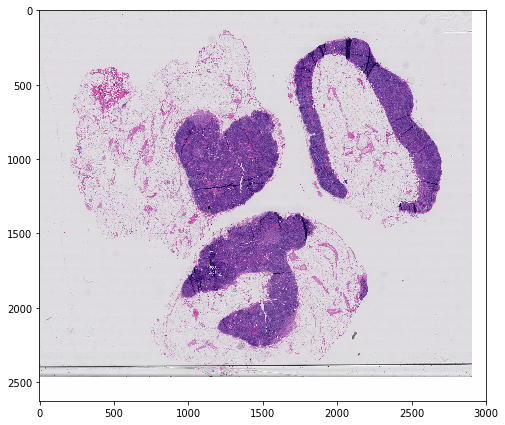

In [13]:
slide = assign_wsi_plus(file, level0=40)
thumb = slide.get_thumbnail(size=(3000,3000))
show_PIL(thumb, size=8)

### View the generated tissue mask

Tissue mask not found. Generating now.
Pickling TissueMask to /home/jevjev/Dropbox/Projects/ImageSampler/Peters/WholeSlideImageSampler/test_data/tissue_masks/Tumor_108_TissueMask.pickle


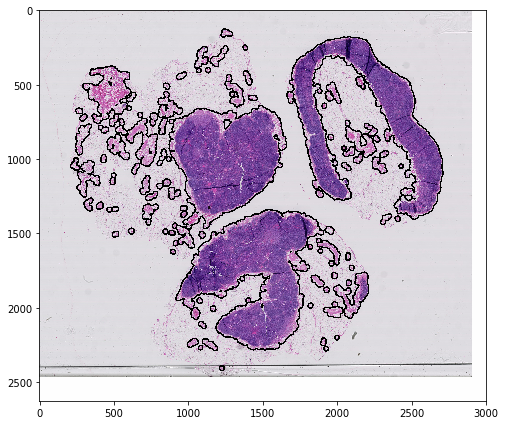

In [14]:
tissue_mask = TissueMask(tissue_mask_dir, reference_wsi=slide)
vis = tissue_mask.visualize(reference_wsi=slide)
show_PIL(vis, size=8)

### Look at a patch

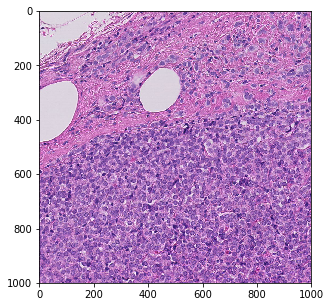

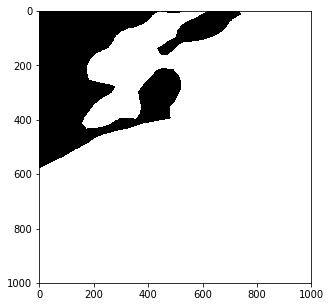

In [15]:
patch = slide.get_patch(w=45000, h=30000, mag=20, size=1000)
show_PIL(patch)

if tumor:
    annotation = Annotation(tumor_annotation, reference_wsi=slide)
    patch = annotation.get_patch(w_ref=45000, h_ref=30000, mag=20, size=1000)
    show_PIL(patch)

### Sample patches

In [16]:
sampler = Sampler(file, level0=40, tissue_mask_dir=tissue_mask_dir, annotation_dir=annotation_dir)
sampler.prepare_sampling(magnification=20, patchsize=200)

Tissue mask found. Loading.
Annotation mask found. Loading.


In [17]:
patchframe = sampler.sample_patches(max_per_class=20, savedir=os.getcwd())

Rejected 17 patches for file Tumor_108
Saving patchframe to /home/jevjev/Dropbox/Projects/ImageSampler/Peters/WholeSlideImageSampler/Tumor_108_patchframe.pickle


In [18]:
save_patchframe_patches(patchframe, './patches') # look in this directory

Saving hard copies of patches in patchframe to ./patches.


# JP2 format (requires matlab engine!)

### Load sample data

In [19]:
# Matlab engine has to receive full path unfortunately
file = os.path.join(path, 'Angus_tumour_10.jp2')
print(file)

/home/jevjev/Dropbox/Projects/ImageSampler/Peters/WholeSlideImageSampler/test_data/Angus_tumour_10.jp2


In [20]:
engine = get_matlab_engine()

In [21]:
slide = assign_wsi_plus(file, level0=20, engine=engine) # Given engine it will automatically select JP2Open

### Generate tissue mask

Note that thumbnail generation with jp2 images is not yet available. Annotation class has not been tested yet with jp2 images as well. But we are working on fixing both!

**You must pass engine with functions that call WSI object**, this is done for efficiency so that new instance of matlab engine does not have to be created every time.

In [23]:
tissue_mask = TissueMask(tissue_mask_dir, reference_wsi=slide)

Tissue mask not found. Generating now.
Pickling TissueMask to /home/jevjev/Dropbox/Projects/ImageSampler/Peters/WholeSlideImageSampler/test_data/tissue_masks/Angus_tumour_10_TissueMask.pickle


### Look at a patch

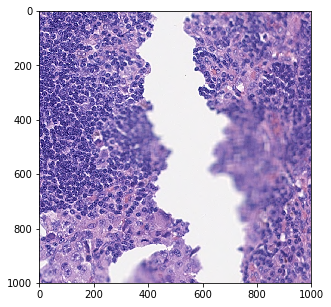

In [33]:
patch = slide.get_patch(w=43264, h=83072, mag=20, size=1000)
show_PIL(patch)

### Sample patches

In [34]:
sampler = Sampler(file, level0=20, tissue_mask_dir=tissue_mask_dir, annotation_dir=None, engine=engine) # Make sure to pass engine into the sampler
sampler.prepare_sampling(magnification=20, patchsize=200)

Tissue mask found. Loading.


In [35]:
patchframe = sampler.sample_patches(max_per_class=20, savedir=os.getcwd())

Rejected 0 patches for file Angus_tumour_10
Saving patchframe to /home/jevjev/Dropbox/Projects/ImageSampler/Peters/WholeSlideImageSampler/Angus_tumour_10_patchframe.pickle


In [36]:
save_patchframe_patches(patchframe, './patches', engine=engine) # look in this directory

Saving hard copies of patches in patchframe to ./patches.
